In [3]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np
from scipy.special import gamma
from scipy import signal
import time
import fathon
import itertools
from itertools import combinations
try:
    from tqdm import tqdm_notebooks as tqdm
except ImportError:
    tqdm = lambda x: x
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
###
from collections import defaultdict

from scipy.stats import pearsonr, zscore
from MFDFA import fgn
# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()
from tqdm import tqdm


import matplotlib as mpl
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')
import shogun as sg
from shogun import *
from scipy.stats import norm, laplace
import random
import shogunMMDutils as mmdutils

# import stylised_facts_data_utilities.createLOB as createLOB
# import stylised_facts_data_utilities.gpyNARX as gpyNARX
# import stylised_facts_data_utilities.longtaildistr as longtail
%matplotlib inline

plt.style.use(os.path.join(mpl.get_configdir(),'latexstyle.mplstyle'))

In [4]:
import shogun as sg

In [5]:
graphicsLocation = '/home/ak/Documents/Research/Papers/StylisedFactsPaper/figures'

In [6]:
def shogun_features(x, y):
    # create shogun features
    return [RealFeatures(x.reshape(1, len(x))), RealFeatures(y.reshape(1, len(y)))]

In [7]:
# locations
ActivityCLockData = '/media/ak/My Passport/Experiment Data/ActivityClockData/'
OHLCData = '/media/ak/My Passport/Experiment Data/OHLCData/'
folderList = os.listdir(ActivityCLockData)
OHLCDataList = os.listdir(OHLCData)
ActivityClockDataList = os.listdir(ActivityCLockData)
# this bit is duplicate we need to put it in one place and pull through
JB1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('JB1') in s])
FV1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('FV1') in s])
G1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('G_1') in s])
DU1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('DU1') in s])
FB1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('FB1') in s])
AllClocksData = [DU1ClocksData, FB1ClocksData, JB1ClocksData, FV1ClocksData, G1ClocksData]
symbols = ['FB1', 'JB1', 'FV1', 'G_1', 'DU1']

types_of_bars = ['OriginalDF', 'TickBarDf', 'VolumeBarDf', 'DollarVolumeBarDf']  # types of bars availabe
pklClockFile_locations = ["".join((ActivityCLockData, clocksDataList[pklIdx])) for clocksDataList in AllClocksData
                          for pklIdx in range(0, 25)]

# Single Symbol Location etc. this may be redundant
symbol_idx = 4
single_symbol_clocks_locations = np.sort([s for s in pklClockFile_locations if (str(symbols[symbol_idx])) in s])
single_symbol_dataFrames = [pickle.load(open(pklClockFile, "rb"))[frame] for pklClockFile in
                            single_symbol_clocks_locations for frame in
                            types_of_bars]
single_dict_frames ={(pklClockFile.split("_")[-2], str(frame)):pickle.load(open(pklClockFile , "rb"))[frame] for pklClockFile in single_symbol_clocks_locations for frame in types_of_bars }
single_symbol_key_dates = [pklClockFile.split("_")[-2] for pklClockFile in single_symbol_clocks_locations]

# now lets get all the data out for each type of frame
idx = 0
date_bar_type_keys = [(date, types_of_bars[idx]) for date in single_symbol_key_dates]
mpc_dict_frames = {i: single_dict_frames[date_bar_type_keys[i]].MicroPrice for i in range(len(date_bar_type_keys))}

{0: 0        111.917375
 1        111.917522
 2        111.917520
 3        111.917495
 4        111.917424
 5        111.917984
 6        111.917997
 7        111.918154
 8        111.918201
 9        111.918250
 10       111.918271
 11       111.918256
 12       111.918299
 13       111.918271
 14       111.918187
 15       111.918054
 16       111.917931
 17       111.917801
 18       111.917769
 19       111.917751
 20       111.917769
 21       111.917790
 22       111.917460
 23       111.917451
 24       111.917449
 25       111.917375
 26       111.917360
 27       111.917013
 28       111.917006
 29       111.917126
             ...    
 22158    111.902531
 22159    111.902524
 22160    111.902523
 22161    111.902441
 22162    111.902364
 22163    111.902285
 22164    111.902350
 22165    111.902363
 22166    111.902331
 22167    111.902103
 22168    111.902097
 22169    111.902086
 22170    111.902099
 22171    111.902227
 22172    111.902037
 22173    111.902069
 22174    

In [4]:
# removes extremities based on two inputs
def series_between_percentiles(series, upperValue,lowerValue):
    # Find out percentiles and get values in between
    lThres = np.percentile(series , lowerValue) # lower percentile
    uThres = np.percentile(series , upperValue) # higher percentile
    return series[(series > lThres) & (series <uThres)]

In [9]:
# import numerical libraries

from scipy import stats
# import tableone
try:
    from tableone import TableOne
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import TableOne

### Assumptions and Investigations

1/ By moving to the tick domain, the need to force each trade into a time slot is removed as one does
not need to force the trades into predetermined sampling points as in calendar time. Additionally, when using calendar time sampling

2/ can we recover normality in each of the assets and periods?

3/duration between trades is
also added to the subordination framework to account for
the speed with which market participants act in physical
time.

4/we bring qualitative empirical evidence that the impact of a single
trade depends on the intertrade time lags. We find that when the trading rate be- comes faster, the return variance per trade strongly increases and that this behavior persists at coarser time scales. 

5/So we answer the following question: is the realized variance created by 10 trades arriving over 10 seconds similar to the realized variance created by those very same trades had they arrived during 10 minutes? Any model that uses a transaction time clock implies that the two situations are similar. Our empirical findings show that they are not, and that trades arriving in a shorter duration have higher variance, thus showing the importance of the physical inter-trade time duration. 

In [28]:
import fathon
from fathon import fathonUtils as fu

In [13]:
mpc_keys = list(mpc_dict_frames.keys())

In [26]:
idx= 1
lead = 5
A = np.array(mpc_dict_frames[mpc_keys[idx]].pct_change().dropna()).reshape(len(mpc_dict_frames[mpc_keys[idx]].pct_change().dropna(),))
B = np.array(mpc_dict_frames[mpc_keys[idx + lead]].pct_change().dropna()).reshape(len(mpc_dict_frames[mpc_keys[idx+ lead]].pct_change().dropna(),))


In [29]:
a = fu.toAggregated(A)
b = fu.toAggregated(B)

In [38]:
pydfa = fathon.DFA(a)

In [39]:
winSizes = fu.linRangeByStep(10, 2000)
revSeg = True
polOrd = 3

In [40]:
%%time
n, F = pydfa.computeFlucVec(winSizes, revSeg=revSeg, polOrd=polOrd)

CPU times: user 1min 40s, sys: 88.1 ms, total: 1min 41s
Wall time: 35.8 s


In [41]:
H, H_intercept = pydfa.fitFlucVec()

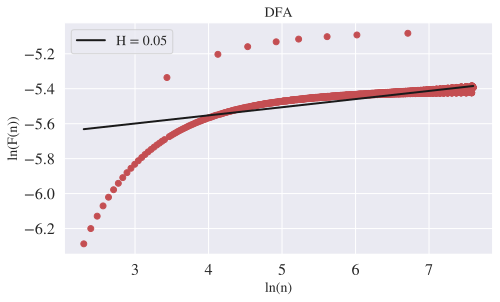

In [42]:
plt.plot(np.log(n), np.log(F), 'ro')
plt.plot(np.log(n), H_intercept+H*np.log(n), 'k-', label='H = {:.2f}'.format(H))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('DFA', fontsize=14)
plt.legend(loc=0, fontsize=14)

In [43]:
limits_list = np.array([[15,2000], [200,1000]], dtype=int)
list_H, list_H_intercept = pydfa.multiFitFlucVec(limits_list)

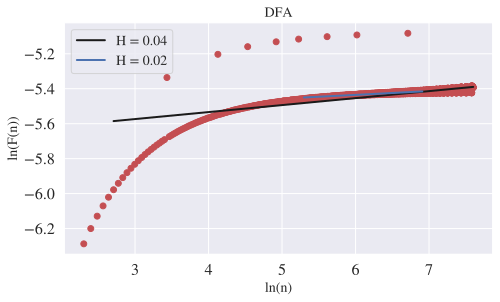

In [44]:
clrs = ['k', 'b', 'm', 'c', 'y']
stls = ['-', '--', '.-']
plt.plot(np.log(n), np.log(F), 'ro')
for i in range(len(list_H)):
    n_rng = np.arange(limits_list[i][0], limits_list[i][1]+1)
    plt.plot(np.log(n_rng), list_H_intercept[i]+list_H[i]*np.log(n_rng),
             clrs[i%len(clrs)]+stls[(i//len(clrs))%len(stls)], label='H = {:.2f}'.format(list_H[i]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('DFA', fontsize=14)
plt.legend(loc=0, fontsize=14)

### PYMFDFA

In [46]:
pymfdfa = fathon.MFDFA(a)

In [49]:
winSizes = fu.linRangeByStep(10, 2000)
qs = np.arange(-3, 4, 0.1)
revSeg = True
polOrd = 1

n, F = pymfdfa.computeFlucVec(winSizes, qs, revSeg=revSeg, polOrd=polOrd)

In [50]:
list_H, list_H_intercept = pymfdfa.fitFlucVec()

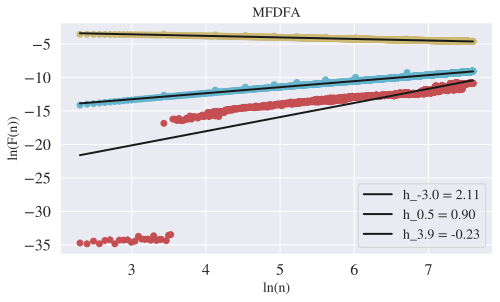

In [51]:
plt.plot(np.log(n), np.log(F[0, :]), 'ro')
plt.plot(np.log(n), list_H_intercept[0]+list_H[0]*np.log(n), 'k-', label='h_{:.1f} = {:.2f}'.format(qs[0], list_H[0]))
half_idx = int(len(qs)/2)
plt.plot(np.log(n), np.log(F[half_idx, :]), 'co')
plt.plot(np.log(n), list_H_intercept[half_idx]+list_H[half_idx]*np.log(n),
         'k-', label='h_{:.1f} = {:.2f}'.format(qs[half_idx], list_H[half_idx]))
plt.plot(np.log(n), np.log(F[-1, :]), 'yo')
plt.plot(np.log(n), list_H_intercept[-1]+list_H[-1]*np.log(n), 'k-',
         label='h_{:.1f} = {:.2f}'.format(qs[-1], list_H[-1]))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('MFDFA', fontsize=14)
plt.legend(loc=0, fontsize=14)